# Notebook Overview

tsfresh is a Python package that computes more than 750 time series features from each original feature. It also provides a feature selection algorithm that identifies the most predictive features. The challenge with tsfresh is that to run it on a dataframe with over 1 million rows becomes very difficult on most machines. Therefore, in a separate notebook it was run for each month, combined into one overall dataframe with the most relevant features and saved as a csv file. That file is used here and those features are added to the overall dataset. 

The notebook where tsfresh was run for each month and combined is found here: https://www.kaggle.com/code/twinpilgrim/store-sales-running-tsfresh-in-monthly-batches

This notebook also focuses on embedding time into the features, running the models on each family before combining the predictions, and then using a blended XGBRegressor and Catboost model for the final predictions.

In [1]:
import numpy as np 
import pandas as pd 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train = pd.read_csv('train.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
test = pd.read_csv('test.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)

# Creating New Features

To combine the training and test datasets for feature engineering, both as a convenience and to account for carrying some of the temporal embedding of the features from the later period of the training dataset into the test dataset. 

In [3]:
train_test = pd.concat([train, test], ignore_index=True)

To change convert the date column into a datetime datatype and then to break out some basic calendar items as separate features. 

In [4]:
train_test.date = pd.to_datetime(train_test.date)

train_test['year'] = train_test.date.dt.year
train_test['month'] = train_test.date.dt.month
train_test['dayofmonth'] = train_test.date.dt.day
train_test['dayofweek'] = train_test.date.dt.dayofweek
train_test['dayname'] = train_test.date.dt.strftime('%A')

In [5]:
oil = pd.read_csv('oil.csv', parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')

To create a rolling 7 day mean as a basis for looking for trends in oil, create a separate dataframe to explore these trends and then forward fill missing data from the beginning of the 7 day rolling average values. Also tried 28 day rolling average for oil, but that increased the prediction scores. 

In [6]:
oil['avg_oil_7'] = oil['dcoilwtico'].rolling(7).mean()

In [7]:
trends = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31')).to_period('D')
trends = trends.join(oil, how='outer')
trends['avg_oil_7'].fillna(method = 'ffill', inplace = True)
trends.dropna(inplace = True)

Autocorrelation looks at the correlation of the values of a time series in successive periods. Partial autocorrelation removes any indirect correlation that may be present. Taking the 7 day rolling average for oil and projecting it forward 12 days shows that the first three lags have the most influence. Therefore 3 lags are added to the overall features. 

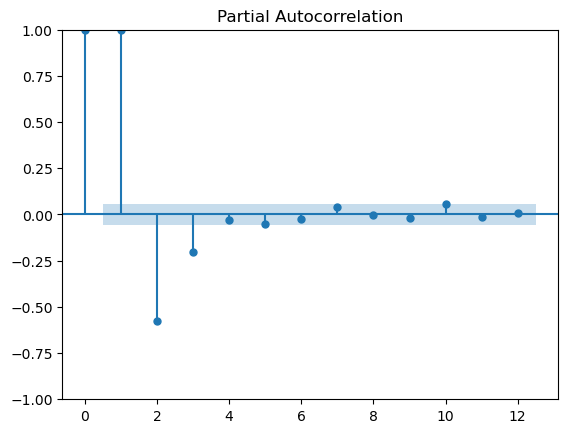

In [8]:
_ = plot_pacf(trends.avg_oil_7, lags = 12)

In [9]:
n_lags = 3
for l in range(1, n_lags+1):
    trends[f'oil_lags7_{l}'] = trends.avg_oil_7.shift(l)
trends.dropna(inplace = True)
trends.count()

dcoilwtico     1166
avg_oil_7      1166
oil_lags7_1    1166
oil_lags7_2    1166
oil_lags7_3    1166
dtype: int64

In [10]:
trends['date_str'] = trends.index.astype(str)
trends.drop('dcoilwtico', axis=1, inplace=True)

In [11]:
trends

,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3,date_str
2013-01-15,93.490000,93.470000,93.284286,93.218571,2013-01-15
2013-01-16,93.644286,93.490000,93.470000,93.284286,2013-01-16
2013-01-17,93.970000,93.644286,93.490000,93.470000,2013-01-17
2013-01-18,94.331429,93.970000,93.644286,93.490000,2013-01-18
2013-01-22,94.331429,94.331429,93.970000,93.644286,2013-01-22
...,...,...,...,...,...
2017-08-25,47.720000,47.598571,47.645714,47.522857,2017-08-25
2017-08-28,47.624286,47.720000,47.598571,47.645714,2017-08-28
2017-08-29,47.320000,47.624286,47.720000,47.598571,2017-08-29
2017-08-30,47.115714,47.320000,47.624286,47.720000,2017-08-30


The first day is missing oil data, so that is filled with the same value as the day after. 

There are also a number of days, primarily on weekends, where there is no oil data. Those dates are identified and then filled with the linear method. This method essentially draws a line between the two observed points and then filling the missing values so that they lie on this line. 

In [12]:
oil = oil.interpolate(method='linear')
oil.iloc[0] = oil.iloc[1]

start_date = train_test.date.min() 
number_of_days = 1704 
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date = (pd.Series(date_list)).to_frame()
date.columns = ['date']
date.date = pd.to_datetime(date.date)
date['date_str'] = date.date.astype(str)
oil['date_str'] = oil.index.astype(str)

oil = pd.merge(date,oil,how='left',on='date_str')
oil = oil.set_index('date').dcoilwtico.interpolate(method='linear').to_frame()
oil['date_str'] = oil.index.astype(str)

To add the oil and trends data to the primary train_test dataframe. 

In [13]:
train_test['date_str'] = train_test.date.astype(str)
train_test = pd.merge(train_test,oil,how='left',on='date_str')

In [14]:
train_test = pd.merge(train_test,trends,how='left',on='date_str')
train_test.drop(columns='date_str',axis=1,inplace=True)

In [15]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286


Creating new 7 day and 28 day rolling time features for promotions had a positive impact on the submission scores. 

In [16]:
train_test['onpromo_7'] = train_test['onpromotion'].rolling(7).mean()
train_test['onpromo_28'] = train_test['onpromotion'].rolling(28).mean()

In [17]:
train_test['onpromo_7'].fillna(0, inplace=True)
train_test['onpromo_28'].fillna(0, inplace=True)

To add the stores data to the train_test dataframe. 

In [18]:
stores = pd.read_csv('stores.csv',index_col='store_nbr')
train_test = pd.merge(train_test,stores,how='left',on='store_nbr')

To create national holiday features, including the core national holiday feature, a national event feature, a national work day feature and identifying weekend days. 

In [19]:
holiday = pd.read_csv('holidays_events.csv')
holiday.query('transferred==True')

holiday = holiday.query('transferred ==False')
holiday.description = holiday.description.str.replace('Traslado ','')

national = holiday.query('locale=="National"')
day_off = national.query('type!="Work Day" or type!="Event"').set_index('date')['description'].to_dict()
train_test['date_str'] = train_test.date.astype(str)
train_test['national_holiday'] = [1 if a in day_off else 0 for a in train_test.date_str]

event = national.query('type=="Event"').set_index('date')['description'].to_dict()
train_test['national_event'] =[1 if a in event else 0 for a in train_test.date_str]

work_day = national.query('type=="Work Day"').set_index('date')['description'].to_dict()
train_test['national_workday'] = [1 if a in work_day else 0 for a in train_test.date_str]

train_test['weekend'] = [1 if a>=5 else 0 for a in train_test.dayofweek]

To identify the local and regional holidays and add them to the train_test dataset. 

In [20]:
local = holiday.query('locale=="Local"')
local_dic = local.set_index('date').locale_name.to_dict()
train_test['local_holiday']=[1 if b in local_dic and local_dic[b]== a else 0 for a,b in zip(train_test.city,train_test.date_str)]

In [21]:
regional = holiday.query('locale=="Regional"')
regional_dic = regional.set_index('date').locale_name.to_dict()
train_test['regional_holiday']= [1 if b in regional_dic and regional_dic[b]== a else 0 for a,b in zip(train_test.state,train_test.date_str)]

In [22]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,state,type,cluster,date_str,national_holiday,national_event,national_workday,weekend,local_holiday,regional_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0


To log transform the sales data to reduce variance and skewness. 

In [23]:
train_test.sales = np.log1p(train_test.sales)

In [24]:
len(train_test.query('date_str=="2013-01-01"'))

1782

To create forward lags for sales for one week, the 16 days needed for the prediction, and then 6 days past the 16th day (a forward week), for one month (28, 30, 31 days), and one year. Since each day has 1782 rows (stores times families), each value is multiplied by 1782. 

In [25]:
train_test['Istest'] = False

train_test['Lag_7'] = train_test['sales'].shift(1782*7)

train_test['Lag_16'] = train_test['sales'].shift(1782*16)
train_test['Lag_17'] = train_test['sales'].shift(1782*17)
train_test['Lag_18'] = train_test['sales'].shift(1782*18)
train_test['Lag_19'] = train_test['sales'].shift(1782*19)
train_test['Lag_20'] = train_test['sales'].shift(1782*20)
train_test["Lag_21"] = train_test['sales'].shift(1782*21)
train_test['Lag_22'] = train_test['sales'].shift(1782*22)

train_test['Lag_28'] = train_test['sales'].shift(1782*28)
train_test['Lag_30'] = train_test['sales'].shift(1782*30)
train_test['Lag_31'] = train_test['sales'].shift(1782*31)

train_test['Lag_365'] = train_test['sales'].shift(1782*365)

train_test = train_test.query('Istest==False')

An exponential moving average is a type of moving average that gives more weight to recent observations, which means it’s able to capture recent trends more quickly. Alpha, which ranges from 0 to 1, determines how important the current observation is in the calculation of the EWMA. Alpha represents the degree of weighting decrease and is a constant smoothing factor. A higher alpha discounts older data faster thereby placing greater relevance on your more current data.

Below this is done for a range of alphas between 0.95 and 0.5, and for 1 day, 1 week, and one month. 

In [26]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            feature_name = 'sales_ewm_alpha_' + str(alpha).replace(".", "") + '_lag_' + str(lag)
            dataframe[feature_name] = dataframe.groupby(["store_nbr", "family"])['sales'].\
                transform(lambda x: x.shift(lag).ewm(alpha=alpha, min_periods=1).mean())
    return dataframe

In [27]:
alphas = [0.95, 0.8, 0.65, 0.5]
lags =[1, 7,30]
train_test = ewm_features(train_test, alphas, lags)

From the correlation data it appears the lowest alphas and lowest lags have the highest correlations to sales. Which means the older data is still important as part of the EWM calculations. 

In [28]:
corr = train_test.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.975231
sales_ewm_alpha_065_lag_1     0.973496
sales_ewm_alpha_08_lag_1      0.971192
sales_ewm_alpha_05_lag_7      0.971186
sales_ewm_alpha_065_lag_7     0.970779
sales_ewm_alpha_08_lag_7      0.969665
sales_ewm_alpha_095_lag_1     0.968111
sales_ewm_alpha_095_lag_7     0.967665
Lag_7                         0.966752
Lag_21                        0.947122
Lag_16                        0.941619
Lag_17                        0.939454
Lag_20                        0.939114
Lag_18                        0.938127
Lag_28                        0.937857
Lag_19                        0.937607
Lag_22                        0.935959
sales_ewm_alpha_05_lag_30     0.934552
sales_ewm_alpha_065_lag_30    0.931726
sales_ewm_alpha_08_lag_30     0.928695
sales_ewm_alpha_095_lag_30    0.925129
Lag_30                        0.923753
Lag_31                        0.922037
Lag_365                       0.850742
onpromotion              

Since lags have NaNs in the first part of their time periods, these are filled with 0 values. 

In [29]:
lags = ['Lag_7','Lag_16','Lag_17','Lag_18','Lag_19','Lag_20','Lag_21','Lag_22','Lag_28', 'Lag_30','Lag_31','Lag_365',
       'oil_lags7_1', 'oil_lags7_2', 'oil_lags7_3', 'avg_oil_7', 'sales_ewm_alpha_095_lag_1', 'sales_ewm_alpha_095_lag_7',
        'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_08_lag_1', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_30',
        'sales_ewm_alpha_065_lag_1', 'sales_ewm_alpha_065_lag_7', 'sales_ewm_alpha_065_lag_30', 'sales_ewm_alpha_05_lag_1',
        'sales_ewm_alpha_05_lag_7', 'sales_ewm_alpha_05_lag_30']

In [30]:
train_test[lags]=train_test[lags].fillna(0)

In experimenting with the dates it was found that the best results came from only including the data from 2016 forward. 

In [31]:
train_test = train_test.query("date >= '2016-01-01' ")

In [32]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_065_lag_1,sales_ewm_alpha_065_lag_7,sales_ewm_alpha_065_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,2016,1,1,4,Friday,...,1.317202,1.803400,1.677389,1.122943,1.817994,1.697249,0.973111,1.827742,1.657195,0.892811
1945945,2016-01-01,1,BABY CARE,0.0,0,2016,1,1,4,Friday,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1945946,2016-01-01,1,BEAUTY,0.0,0,2016,1,1,4,Friday,...,1.943741,0.178375,1.221152,1.908997,0.274128,1.293594,1.828294,0.374116,1.354975,1.702942
1945947,2016-01-01,1,BEVERAGES,0.0,0,2016,1,1,4,Friday,...,7.804765,7.711394,7.735110,7.773221,7.703508,7.747519,7.724412,7.668357,7.747519,7.670928
1945948,2016-01-01,1,BOOKS,0.0,0,2016,1,1,4,Friday,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,...,6.338358,6.012643,6.012643,6.311631,5.977488,5.977488,6.283037,5.957384,5.957384,6.244803
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,...,3.953042,4.984993,4.984993,4.014010,4.938647,4.938647,4.105066,4.894600,4.894600,4.210488
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,...,7.788738,7.682595,7.682595,7.722496,7.606924,7.606924,7.659226,7.532320,7.532320,7.590557
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,...,5.253514,4.885929,4.885929,5.043656,4.941502,4.941502,4.787096,4.982981,4.982981,4.438414


# Using the TSFresh Features

As mentioned above the notebook where the tsfresh features were created is here: https://www.kaggle.com/code/twinpilgrim/store-sales-running-tsfresh-in-monthly-batches

In [33]:
tsfresh_features = pd.read_csv('tsfresh_features.csv', index_col=0)

As can be seen, tsfresh created 50 additional features. The additional features for onpromotion were created for all rows while the features for dcoilwtico were created for about half the rows. 

In [34]:
tsfresh_features

,onpromotion__sum_values,onpromotion__value_count__value_0,onpromotion__value_count__value_1,onpromotion__count_below__t_0,onpromotion__range_count__max_1__min_-1,"onpromotion__fft_coefficient__attr_""abs""__coeff_0","onpromotion__fft_coefficient__attr_""real""__coeff_0","onpromotion__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","onpromotion__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","onpromotion__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",...,dcoilwtico__quantile__q_0.1,dcoilwtico__minimum,dcoilwtico__absolute_maximum,dcoilwtico__maximum,dcoilwtico__root_mean_square,dcoilwtico__mean,dcoilwtico__median,dcoilwtico__sum_values,dcoilwtico__quantile__q_0.6,dcoilwtico__benford_correlation
1945944,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
1945945,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
1945946,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
1945947,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
1945948,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.193940,0.274272,0.387880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3029396,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3029397,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.193940,0.274272,0.387880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3029398,9.0,0.0,0.0,0.0,0.0,9.0,9.0,1.745458,2.468450,3.490916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
tsfresh_features.isna().sum()

onpromotion__sum_values                                                     0
onpromotion__value_count__value_0                                           0
onpromotion__value_count__value_1                                           0
onpromotion__count_below__t_0                                               0
onpromotion__range_count__max_1__min_-1                                     0
onpromotion__fft_coefficient__attr_"abs"__coeff_0                           0
onpromotion__fft_coefficient__attr_"real"__coeff_0                          0
onpromotion__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)         0
onpromotion__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)         0
onpromotion__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)          0
onpromotion__quantile__q_0.9                                                0
onpromotion__quantile__q_0.8                                                0
onpromotion__quantile__q_0.7                                    

From the describe output below most of the dcoilwtico new features have a narrow band of values where the mean and median are close together. If these features are going to be used it would make sense to fill the NaN values with the mean. However, in reality the results were better by just filling the NaNs with 0s. 

In [36]:
tsfresh_features.describe()

,onpromotion__sum_values,onpromotion__value_count__value_0,onpromotion__value_count__value_1,onpromotion__count_below__t_0,onpromotion__range_count__max_1__min_-1,"onpromotion__fft_coefficient__attr_""abs""__coeff_0","onpromotion__fft_coefficient__attr_""real""__coeff_0","onpromotion__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","onpromotion__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","onpromotion__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",...,dcoilwtico__quantile__q_0.1,dcoilwtico__minimum,dcoilwtico__absolute_maximum,dcoilwtico__maximum,dcoilwtico__root_mean_square,dcoilwtico__mean,dcoilwtico__median,dcoilwtico__sum_values,dcoilwtico__quantile__q_0.6,dcoilwtico__benford_correlation
count,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,1.083456e+06,...,490050.000000,490050.000000,490050.000000,490050.000000,490050.000000,490050.000000,490050.000000,490050.000000,490050.000000,324324.000000
mean,5.965014e+00,6.090132e-01,8.877979e-02,6.090132e-01,6.090132e-01,5.965014e+00,5.965014e+00,1.156853e+00,1.636038e+00,2.313707e+00,...,46.328618,46.328618,46.328618,46.328618,46.328618,46.328618,46.328618,46.328618,46.328618,-0.054206
std,1.816017e+01,4.879717e-01,2.844258e-01,4.879717e-01,4.879717e-01,1.816017e+01,1.816017e+01,3.521980e+00,4.980832e+00,7.043961e+00,...,6.224776,6.224776,6.224776,6.224776,6.224776,6.224776,6.224776,6.224776,6.224776,0.104857
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,26.680000,26.680000,26.680000,26.680000,26.680000,26.680000,26.680000,26.680000,26.680000,-0.145280
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,44.240000,44.240000,44.240000,44.240000,44.240000,44.240000,44.240000,44.240000,44.240000,-0.145280
50%,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,47.460000,47.460000,47.460000,47.460000,47.460000,47.460000,47.460000,47.460000,47.460000,-0.064614
75%,3.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.000000e+00,3.000000e+00,5.818193e-01,8.228168e-01,1.163639e+00,...,51.120000,51.120000,51.120000,51.120000,51.120000,51.120000,51.120000,51.120000,51.120000,-0.064614
max,7.410000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.410000e+02,7.410000e+02,1.437094e+02,2.032358e+02,2.874188e+02,...,54.010000,54.010000,54.010000,54.010000,54.010000,54.010000,54.010000,54.010000,54.010000,0.295657


The first option that was tried was to only include the rows that had no NaN values and therefore represented all the columns, as created in the tsfresh_features_subset dataframe. However the results of doing this were not as good as including all the rows and filling the NaNs with 0s. 

In [37]:
tsfresh_features_subset = tsfresh_features[tsfresh_features.columns[~tsfresh_features.isnull().any()]]

In [38]:
tsfresh_features_subset

,onpromotion__sum_values,onpromotion__value_count__value_0,onpromotion__value_count__value_1,onpromotion__count_below__t_0,onpromotion__range_count__max_1__min_-1,"onpromotion__fft_coefficient__attr_""abs""__coeff_0","onpromotion__fft_coefficient__attr_""real""__coeff_0","onpromotion__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","onpromotion__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","onpromotion__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)",...,onpromotion__quantile__q_0.6,onpromotion__root_mean_square,onpromotion__maximum,onpromotion__absolute_maximum,onpromotion__mean,onpromotion__benford_correlation,onpromotion__quantile__q_0.1,onpromotion__quantile__q_0.2,onpromotion__quantile__q_0.3,onpromotion__minimum
1945944,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.864123,0.0,0.0,0.0,0.0
1945945,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.864123,0.0,0.0,0.0,0.0
1945946,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.864123,0.0,0.0,0.0,0.0
1945947,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.864123,0.0,0.0,0.0,0.0
1945948,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.864123,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.193940,0.274272,0.387880,...,1.0,1.0,1.0,1.0,1.0,0.864123,1.0,1.0,1.0,1.0
3029396,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.295657,0.0,0.0,0.0,0.0
3029397,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.193940,0.274272,0.387880,...,1.0,1.0,1.0,1.0,1.0,0.864123,1.0,1.0,1.0,1.0
3029398,9.0,0.0,0.0,0.0,0.0,9.0,9.0,1.745458,2.468450,3.490916,...,9.0,9.0,9.0,9.0,9.0,-0.297356,9.0,9.0,9.0,9.0


As mentioned above the best results came from including all the rows and simply filling the NaNs with 0s. 

In [39]:
tsfresh_features_all=tsfresh_features.fillna(0)

In [40]:
tsfresh_features_all.isna().sum()

onpromotion__sum_values                                                0
onpromotion__value_count__value_0                                      0
onpromotion__value_count__value_1                                      0
onpromotion__count_below__t_0                                          0
onpromotion__range_count__max_1__min_-1                                0
onpromotion__fft_coefficient__attr_"abs"__coeff_0                      0
onpromotion__fft_coefficient__attr_"real"__coeff_0                     0
onpromotion__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)    0
onpromotion__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)    0
onpromotion__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)     0
onpromotion__quantile__q_0.9                                           0
onpromotion__quantile__q_0.8                                           0
onpromotion__quantile__q_0.7                                           0
onpromotion__cwt_coefficients__coeff_0__w_2__widths

These tsfresh features were then joined into the main dataframe with the temporary dataframe train_test_tsfresh. Once this was successful, it became the core train_test dataframe. 

In [41]:
#train_test_tsfresh = train_test.join(tsfresh_features_subset)
train_test_tsfresh = train_test.join(tsfresh_features_all)

In [42]:
train_test_tsfresh

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,dcoilwtico__quantile__q_0.1,dcoilwtico__minimum,dcoilwtico__absolute_maximum,dcoilwtico__maximum,dcoilwtico__root_mean_square,dcoilwtico__mean,dcoilwtico__median,dcoilwtico__sum_values,dcoilwtico__quantile__q_0.6,dcoilwtico__benford_correlation
1945944,2016-01-01,1,AUTOMOTIVE,0.0,0,2016,1,1,4,Friday,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
1945945,2016-01-01,1,BABY CARE,0.0,0,2016,1,1,4,Friday,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
1945946,2016-01-01,1,BEAUTY,0.0,0,2016,1,1,4,Friday,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
1945947,2016-01-01,1,BEVERAGES,0.0,0,2016,1,1,4,Friday,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
1945948,2016-01-01,1,BOOKS,0.0,0,2016,1,1,4,Friday,...,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,36.97,0.062915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000


In [43]:
train_test = train_test_tsfresh

# Predicting and Submitting the Results

To create the families list that will be iterated over. 

In [44]:
families = ['AUTOMOTIVE','BABY CARE','BEAUTY','BEVERAGES','BOOKS','BREAD/BAKERY','CELEBRATION','CLEANING','DAIRY',
            'DELI','EGGS','FROZEN FOODS','GROCERY I','GROCERY II','HARDWARE','HOME AND KITCHEN I','HOME AND KITCHEN II',
            'HOME APPLIANCES','HOME CARE','LADIESWEAR','LAWN AND GARDEN','LINGERIE','LIQUOR,WINE,BEER','MAGAZINES',
            'MEATS','PERSONAL CARE','PET SUPPLIES','PLAYERS AND ELECTRONICS','POULTRY','PREPARED FOODS','PRODUCE',
            'SCHOOL AND OFFICE SUPPLIES','SEAFOOD']

In [45]:
print(train_test.columns.tolist())

['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month', 'dayofmonth', 'dayofweek', 'dayname', 'dcoilwtico', 'avg_oil_7', 'oil_lags7_1', 'oil_lags7_2', 'oil_lags7_3', 'onpromo_7', 'onpromo_28', 'city', 'state', 'type', 'cluster', 'date_str', 'national_holiday', 'national_event', 'national_workday', 'weekend', 'local_holiday', 'regional_holiday', 'Istest', 'Lag_7', 'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22', 'Lag_28', 'Lag_30', 'Lag_31', 'Lag_365', 'sales_ewm_alpha_095_lag_1', 'sales_ewm_alpha_095_lag_7', 'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_08_lag_1', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_30', 'sales_ewm_alpha_065_lag_1', 'sales_ewm_alpha_065_lag_7', 'sales_ewm_alpha_065_lag_30', 'sales_ewm_alpha_05_lag_1', 'sales_ewm_alpha_05_lag_7', 'sales_ewm_alpha_05_lag_30', 'onpromotion__sum_values', 'onpromotion__value_count__value_0', 'onpromotion__value_count__value_1', 'onpromotion__count_below__t_0', 'onpromotion__range_count_

To identify the features that won't be used as the dependent variables for the prediction process. 

In [46]:
FEATURES = train_test.columns.tolist()
no_features = ('date', 'family', 'sales', 'dayname', 'date_str', 'Istest')

for i in no_features:
    FEATURES.remove(i)
TARGET =['sales']

To use encoding to transform the categorical values to numbers. 

In [47]:
categories = ['city','state', 'type']
for i in categories:
    encoder = preprocessing.LabelEncoder()
    train_test[i] = encoder.fit_transform(train_test[i])

To split back out the training and test dataframes with the new features. 

In [48]:
train = train_test[train_test['sales'].notnull()].copy()
test = train_test[train_test['sales'].isnull()].drop(['sales'],axis=1)

Optuna was used to find the optimal parameters for XBGRegressor. The values below were what were identified. Optuna was also run on Catboost Regressor, but those parameter values - for some reason - did not improve the score from the default parameters. 

In [49]:
params = {'lambda': 6.105970537016599, 
          'alpha': 0.874716179324655, 
          'eta': 0.047228549789593455, 
          'colsample_bytree': 0.5, 
          'subsample': 0.7, 
          'learning_rate': 0.012, 
          'n_estimators': 1000, 
          'max_depth': 17, 
          'min_child_weight': 155,
          'early_stopping_rounds': 10}

The following code runs the fitting and prediction for both catboost and xgb by each product family. Since each family might have their own sales behaviors, this process could provide a more accurate prediction. The overall score using each familty is better than estimating future sales based on the overall, global model.

Also running the predictions for the test dataset in this loop created a better result than running it in a separate loop. 

In [50]:
cat_predictions = []
xgb_predictions = []
y_val_cat = pd.DataFrame()
y_val_xgb = pd.DataFrame()
cat = CatBoostRegressor()
xgb = XGBRegressor(**params)

test_predict = pd.DataFrame()

cat_submit = []
xgb_submit = []

for family in families:
    train_family = train.loc[train['family'] == family]
    X_train_family,X_val_family,y_train_family,y_val_family = train_test_split(train_family,
                                                                               train_family[TARGET],
                                                                               test_size=0.05,shuffle=False)
    
    cat.fit(X_train_family[FEATURES], y_train_family, eval_set=[(X_train_family[FEATURES],y_train_family),
                                                               (X_val_family[FEATURES], y_val_family)], 
            verbose=False,early_stopping_rounds=10)
    
    xgb.fit(X_train_family[FEATURES], y_train_family, eval_set=[(X_train_family[FEATURES],y_train_family),
                                                                (X_val_family[FEATURES], y_val_family)],
            verbose=False)
    
    cat_pred_family = cat.predict(X_val_family[FEATURES])
    cat_pred_family = [a if a>0 else 0 for a in cat_pred_family]
    cat_predictions.extend(cat_pred_family)
    y_val_cat = pd.concat([y_val_cat, y_val_family])
    
    xgb_pred_family = xgb.predict(X_val_family[FEATURES])
    xgb_pred_family = [a if a>0 else 0 for a in xgb_pred_family]
    xgb_predictions.extend(xgb_pred_family)
    y_val_xgb = pd.concat([y_val_xgb, y_val_family])
    
    test_family = test.loc[test['family'] == family]
    
    cat_pred_submit = cat.predict(test_family[FEATURES])
    cat_pred_submit = [a if a>0 else 0 for a in cat_pred_submit]
    cat_submit.extend(cat_pred_submit)
    
    xgb_pred_submit = xgb.predict(test_family[FEATURES])
    xgb_pred_submit = [a if a>0 else 0 for a in xgb_pred_submit]
    xgb_submit.extend(xgb_pred_submit)
    
    test_predict = pd.concat([test_predict, test_family])
    
    print(family,'CatBoost RMSLE:', np.sqrt(mean_squared_log_error(y_val_family, cat_pred_family)))
    print(family,'XGB RMSLE:', np.sqrt(mean_squared_log_error(y_val_family, xgb_pred_family)))

AUTOMOTIVE CatBoost RMSLE: 0.22203247826918487
AUTOMOTIVE XGB RMSLE: 0.22136928392483116
BABY CARE CatBoost RMSLE: 0.18643828137979904
BABY CARE XGB RMSLE: 0.1876460427523692
BEAUTY CatBoost RMSLE: 0.23629837066955056
BEAUTY XGB RMSLE: 0.23669797924730573
BEVERAGES CatBoost RMSLE: 0.023575224483456406
BEVERAGES XGB RMSLE: 0.02362094112543253
BOOKS CatBoost RMSLE: 0.07559293974500046
BOOKS XGB RMSLE: 0.07308171422150996
BREAD/BAKERY CatBoost RMSLE: 0.024744075486192594
BREAD/BAKERY XGB RMSLE: 0.02448086876665574
CELEBRATION CatBoost RMSLE: 0.20313170087929971
CELEBRATION XGB RMSLE: 0.20262234504791138
CLEANING CatBoost RMSLE: 0.03319779906879986
CLEANING XGB RMSLE: 0.03297880986906271
DAIRY CatBoost RMSLE: 0.020638336647642346
DAIRY XGB RMSLE: 0.020457315226737386
DELI CatBoost RMSLE: 0.02777811312028787
DELI XGB RMSLE: 0.02789883332644551
EGGS CatBoost RMSLE: 0.05472755096960073
EGGS XGB RMSLE: 0.05515979175997232
FROZEN FOODS CatBoost RMSLE: 0.05314954692410363
FROZEN FOODS XGB RMSLE:

Once the results are run for each product family, the following code looks at the overall score for the combined family predictions. 

In [51]:
len(cat_predictions)

52767

In [52]:
y_val_cat['pred'] = cat_predictions
y_val_xgb['pred'] = xgb_predictions

In [53]:
y_val_cat

,sales,pred
2948121,1.386294,1.883664
2948154,2.197225,2.199317
2948187,1.098612,1.180031
2948220,1.791759,2.069008
2948253,0.693147,1.018010
...,...,...
3000755,1.386294,1.030637
3000788,3.883109,3.381670
3000821,3.860877,3.692472
3000854,3.191710,3.200904


In [54]:
y_val_xgb

,sales,pred
2948121,1.386294,1.872151
2948154,2.197225,2.243867
2948187,1.098612,1.151237
2948220,1.791759,2.104949
2948253,0.693147,0.976902
...,...,...
3000755,1.386294,0.937191
3000788,3.883109,3.395887
3000821,3.860877,3.621678
3000854,3.191710,3.250132


In [55]:
print('Overall CatBoost RMSLE:', np.sqrt(mean_squared_log_error(y_val_cat['sales'], y_val_cat['pred'])))
print('Overall XGB RMSLE:', np.sqrt(mean_squared_log_error(y_val_xgb['sales'], y_val_xgb['pred'])))

Overall CatBoost RMSLE: 0.16423712524951556
Overall XGB RMSLE: 0.16441423616929882


The test_predict dataset was created in the families iteration loop to match the sorting of the test data against the predictions generated in the iteration process. 

In [56]:
test_predict

,date,store_nbr,family,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,...,dcoilwtico__quantile__q_0.1,dcoilwtico__minimum,dcoilwtico__absolute_maximum,dcoilwtico__maximum,dcoilwtico__root_mean_square,dcoilwtico__mean,dcoilwtico__median,dcoilwtico__sum_values,dcoilwtico__quantile__q_0.6,dcoilwtico__benford_correlation
3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3000921,2017-08-16,10,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3000954,2017-08-16,11,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3000987,2017-08-16,12,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3001020,2017-08-16,13,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029267,2017-08-31,54,SEAFOOD,0,2017,8,31,3,Thursday,47.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029300,2017-08-31,6,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029333,2017-08-31,7,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3029366,2017-08-31,8,SEAFOOD,1,2017,8,31,3,Thursday,47.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The cat_submit and xgb_submit predictions are blended to create overall predictions combining the catboost and xgb results. 

In [57]:
len(cat_submit)

28512

In [58]:
len(xgb_submit)

28512

In [59]:
predictions = [0.5 * a + 0.5 * b for a,b in zip(xgb_submit,cat_submit)] 

In [60]:
len(predictions)

28512

These overall predictions are placed into the test_predict dataset and then that dataset is sorted by the id index so that it will match the formatting of the necessary submission file. 

In [61]:
test_predict['pred'] = predictions
test_predict.sort_index(inplace=True)

In [62]:
test_predict

,date,store_nbr,family,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,...,dcoilwtico__minimum,dcoilwtico__absolute_maximum,dcoilwtico__maximum,dcoilwtico__root_mean_square,dcoilwtico__mean,dcoilwtico__median,dcoilwtico__sum_values,dcoilwtico__quantile__q_0.6,dcoilwtico__benford_correlation,pred
3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.510829
3000889,2017-08-16,1,BABY CARE,0,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013924
3000890,2017-08-16,1,BEAUTY,2,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.641363
3000891,2017-08-16,1,BEVERAGES,20,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.697190
3000892,2017-08-16,1,BOOKS,0,2017,8,16,2,Wednesday,46.80,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,1,2017,8,31,3,Thursday,47.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.869989
3029396,2017-08-31,9,PREPARED FOODS,0,2017,8,31,3,Thursday,47.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.709419
3029397,2017-08-31,9,PRODUCE,1,2017,8,31,3,Thursday,47.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.238681
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,2017,8,31,3,Thursday,47.26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.551190


In [63]:
output = pd.read_csv('sample_submission.csv',index_col='id')
output['sales']= np.expm1(test_predict['pred'])

In [65]:
output

,sales
id,
3000888,3.530484
3000889,0.014022
3000890,4.162202
3000891,2201.152078
3000892,0.053444
...,...
3029395,353.245188
3029396,109.987678
3029397,1391.256132


In [66]:
output.to_csv('./submissions/submit-families_tsfresh.csv')